In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from gensim import corpora
from gensim.models import Phrases
import nltk
import re
import numpy as np
from nltk.corpus import stopwords

In [2]:
df_documents = pd.read_csv('datasets/08_documents.csv')
df_documents.columns

Index(['Unnamed: 0', 'snippet_id', 'document_content', 'claim_id',
       'snippet_date', 'claim_content', 'claim_label', 'similarity_score'],
      dtype='object')

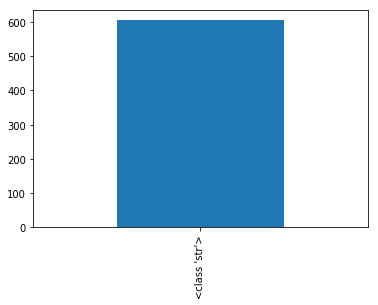

In [3]:
df_type = df_documents[['claim_id','document_content']].copy()
df_type['document_content']=df_type['document_content'].apply(lambda x: str(type(x)))

claim_ids = df_type.sort_values(by=['claim_id','document_content']).groupby('claim_id')\
.first().reset_index().loc[lambda x: x.document_content==str(type('lalala'))][['claim_id']]

df_documents_2 = pd.merge(df_documents,claim_ids)

df_documents_2['document_content'].apply(lambda x: type(x)).value_counts().plot(kind='bar')

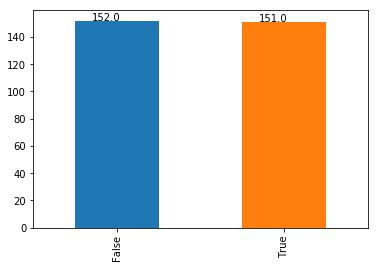

In [4]:
ax = df_documents_2[['claim_id','claim_label']].groupby('claim_id').first().reset_index()['claim_label'].value_counts().plot(kind='bar')
for p in ax.patches:
    ax.annotate(str(int(p.get_height()*1000)/1000), (p.get_x() +0.1, p.get_height() +0.02))

In [5]:
false_claim_ids = df_documents_2[df_documents_2['claim_label']==False][['claim_id','similarity_score']].groupby('claim_id')\
.mean().reset_index().sort_values(by=['similarity_score'], ascending=False).head(151)['claim_id']
print(len(false_claim_ids))
true_claim_ids = df_documents_2[df_documents_2['claim_label']==True][['claim_id','claim_label']].groupby('claim_id')\
.first().reset_index()['claim_id']
print(len(true_claim_ids))
claim_ids = pd.DataFrame(pd.concat([false_claim_ids,true_claim_ids]))
print(len(claim_ids))

151
151
302


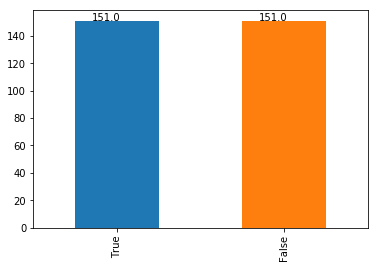

In [6]:
df_documents_3 = pd.merge(df_documents_2,claim_ids)
ax = df_documents_3[['claim_id','claim_label']].groupby('claim_id').first().reset_index()['claim_label'].value_counts().plot(kind='bar')
for p in ax.patches:
    ax.annotate(str(int(p.get_height()*1000)/1000), (p.get_x() +0.1, p.get_height() +0.02))

In [7]:
s_quotes = ['`','´','ʹ','ʻ','ʼ','ʽ','ˊ','ˋ','˴','ʹ','΄','ՙ','՚','՛','՜','՝','‘','’','‛','′','‵', 'ߴ','י' ,'׳', 'ߵ']
d_quotes = ['ʺ','˝','ˮ','˵','˶','ײ','״', '“', '”', '‟', '″', '‴', '‶', '‷','``']

def replace_quotes(st):
    global s_quotes, d_quotes
    for c in s_quotes:
        st = st.replace(c,"'")
    for c in d_quotes:
        st = st.replace(c,'"')
    return st

df_documents_3['document_content'] = df_documents_3['document_content'].apply(lambda x: replace_quotes(x))
df_documents_3['claim_content'] = df_documents_3['claim_content'].apply(lambda x: replace_quotes(x))

In [8]:
garbage = "…[]•™💕🙂🇮🇩→♦☺~∼^★≈≥⌂℠„♫⊕†☆®©¬〇..."

def rm_garbage(st):
    global garbage
    for c in garbage:
        st = st.replace(c,'')
    return st

df_documents_3['document_content'] = df_documents_3['document_content'].apply(lambda x: rm_garbage(x))
df_documents_3['claim_content'] = df_documents_3['claim_content'].apply(lambda x: rm_garbage(x))

In [9]:
df_documents_3['document_content'] = df_documents_3['document_content'].apply(lambda x: x.lower())
df_documents_3['claim_content'] = df_documents_3['claim_content'].apply(lambda x: x.lower())

In [10]:
df_documents_3['snippet_content'] = df_documents_3['document_content'].apply(lambda x: x.replace('â€™s',''))
df_documents_3['snippet_content'] = df_documents_3['document_content'].apply(lambda x: x.replace('€€€',''))
df_documents_3['snippet_content'] = df_documents_3['document_content'].apply(lambda x: x.replace('â€œ',''))
df_documents_3['snippet_content'] = df_documents_3['document_content'].apply(lambda x: x.replace('â€',''))
df_documents_3['snippet_content'] = df_documents_3['document_content'].apply(lambda x: x.replace('â',''))
df_documents_3['snippet_content'] = df_documents_3['document_content'].apply(lambda x: x.replace('\\n',''))
df_documents_3['snippet_content'] = df_documents_3['document_content'].apply(lambda x: x.replace('\\r',''))
df_documents_3['snippet_content'] = df_documents_3['document_content'].apply(lambda x: x.replace('\\t',''))
df_documents_3['snippet_content'] = df_documents_3['document_content'].apply(lambda x: x.replace('\\',''))

df_documents_3['claim_content'] = df_documents_3['claim_content'].apply(lambda x: x.replace('â€™s',''))
df_documents_3['claim_content'] = df_documents_3['claim_content'].apply(lambda x: x.replace('€€€',''))
df_documents_3['claim_content'] = df_documents_3['claim_content'].apply(lambda x: x.replace('â€œ',''))
df_documents_3['claim_content'] = df_documents_3['claim_content'].apply(lambda x: x.replace('â€',''))
df_documents_3['claim_content'] = df_documents_3['claim_content'].apply(lambda x: x.replace('â',''))
df_documents_3['claim_content'] = df_documents_3['claim_content'].apply(lambda x: x.replace('\\n',''))
df_documents_3['claim_content'] = df_documents_3['claim_content'].apply(lambda x: x.replace('\\r',''))
df_documents_3['claim_content'] = df_documents_3['claim_content'].apply(lambda x: x.replace('\\t',''))
df_documents_3['claim_content'] = df_documents_3['claim_content'].apply(lambda x: x.replace('\\',''))

In [11]:
usa_abr = ['u.s.','u.s','u.s…','u.s.-','u.s.—','-u.s.', 
 'u.s..', '\'u.s']
unitednations_abr = ['u.n.']
losangeles_abr = ['l.a.', 'l.a','l.a.','l.a']
unitedkingdom_abr = ['u.k']
newyork_abr = ['n.y.','n.y']
europeanunion_abr = ['e.u']

def replace_abr(st):
    for abr in usa_abr:
        if abr in st:
            st = st.replace(abr,'united states')
    for abr in unitednations_abr:
        if abr in st:
            st = st.replace(abr,'united nations')
    for abr in losangeles_abr:
        if abr in st:
            st = st.replace(abr,'los angeles')
    for abr in unitedkingdom_abr:
        if abr in st:
            st = st.replace(abr, 'united kingdom')
    for abr in newyork_abr:
        if abr in st:
            st = st.replace(abr, 'new york')
    for abr in europeanunion_abr:
        if abr in st:
            st = st.replace(abr, 'european union')
    return st

df_documents_3['document_content'] = df_documents_3['document_content'].apply(lambda x: replace_abr(x))
df_documents_3['claim_content'] = df_documents_3['claim_content'].apply(lambda x: replace_abr(x))

In [12]:
str_sep = '*:•/_–—\\-‐,.|‑…→]―=[~+'

def rm_sep(st):
    for c in str_sep:
        if c in st:
            st = ' '.join(st.split(c))
    return st

df_documents_3['document_content'] = df_documents_3['document_content'].apply(lambda x: rm_sep(x))
df_documents_3['claim_content'] = df_documents_3['claim_content'].apply(lambda x: rm_sep(x))

In [13]:
df_documents_3['document_content'] = df_documents_3['document_content'].apply(lambda x: nltk.word_tokenize(x))
df_documents_3['claim_content'] = df_documents_3['claim_content'].apply(lambda x: nltk.word_tokenize(x))

In [14]:
df_documents_3['document_content'] = df_documents_3['document_content'].apply(lambda x: nltk.pos_tag(x))
df_documents_3['claim_content'] = df_documents_3['claim_content'].apply(lambda x: nltk.pos_tag(x))

In [15]:
worthless_pos_tags = [',', 'PRP$', 'WRB', 'RP', 'TO','(','SYM','WDT', '``', 'WP$', ')', 'EX',
                     'LS', ':', 'WP', 'MD', 'CD', '$', 'IN', '#', "''", 'FW', 'POS', 'DT',
                     '.', 'PDT', 'CC', 'UH', 'PRP']

df_documents_3['document_content'] = df_documents_3['document_content']\
.apply(lambda tb: list(filter(lambda x: x[1] not in worthless_pos_tags,tb)))

df_documents_3['document_content'] = df_documents_3['document_content'].apply(lambda tb: [x[0] for x in tb])

df_documents_3['claim_content'] = df_documents_3['claim_content']\
.apply(lambda tb: list(filter(lambda x: x[1] not in worthless_pos_tags,tb)))

df_documents_3['claim_content'] = df_documents_3['claim_content'].apply(lambda tb: [x[0] for x in tb])

In [16]:
pattern_interest = re.compile("^[a-z']+$")
df_documents_3['document_content'] = df_documents_3['document_content']\
.apply(lambda tb: list(filter(lambda x: pattern_interest.match(x), tb)))
df_documents_3['claim_content'] = df_documents_3['claim_content']\
.apply(lambda tb: list(filter(lambda x: pattern_interest.match(x), tb)))

In [17]:
bigrams = Phrases(list(df_documents_3['snippet_content'].as_matrix()))

df_documents_3['document_content'] = df_documents_3['document_content'].apply(lambda tb: bigrams[tb])
df_documents_3['claim_content'] = df_documents_3['claim_content'].apply(lambda tb: bigrams[tb])

/home/ymerej/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [18]:
stopWords = set(stopwords.words('english'))

df_documents_3['document_content'] = df_documents_3['document_content']\
.apply(lambda tb: list(filter(lambda x: x not in stopWords, tb)))

df_documents_3['claim_content'] = df_documents_3['claim_content']\
.apply(lambda tb: list(filter(lambda x: x not in stopWords, tb)))

376.0
1347.0
2259.0
5261.5
140517.0


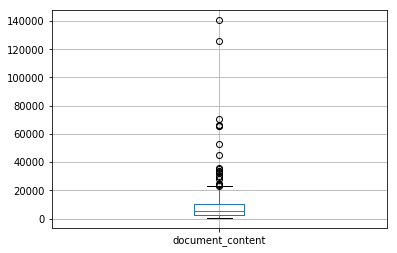

In [19]:
df_documents_count = df_documents_3[['claim_id','claim_label','document_content']].copy()

df_documents_count['document_content'] = df_documents_count['document_content'].apply(lambda x: len(x))

df_document_count = df_documents_count.groupby(['claim_id','claim_label']).sum().reset_index()

print(df_document_count['document_content'].quantile(0.0))
print(df_document_count['document_content'].quantile(0.1))
print(df_document_count['document_content'].quantile(0.25))
print(df_document_count['document_content'].quantile(0.5))
print(df_document_count['document_content'].quantile(1))

df_document_count[['document_content']].boxplot()

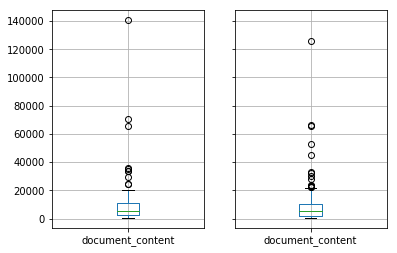

In [20]:
fig, axs = plt.subplots(1,2, sharey = True)
df_document_count[df_document_count['claim_label']==True][['document_content']].boxplot(ax=axs[0])
df_document_count[df_document_count['claim_label']==False][['document_content']].boxplot(ax=axs[1])

In [21]:
print(len(df_documents_3))
df_doc_content = df_documents_3[['claim_id','document_content']].groupby('claim_id').sum().reset_index()
df_doc_similarity = df_documents_3[['claim_id','similarity_score']].groupby('claim_id').mean().reset_index()
df_documents_4 = pd.merge(pd.merge(df_doc_content,df_doc_similarity),
                          df_documents_3[['claim_id','claim_label','claim_content']].groupby('claim_id')\
                          .first().reset_index())
print(len(df_documents_4))

604
302


In [22]:
df_documents_4.to_csv('datasets/09_bow_documents.csv')

In [22]:
dictionary_documents = corpora.Dictionary(list(df_documents_4['document_content'].as_matrix()))
dictionary_claims = corpora.Dictionary(list(df_documents_4['claim_content'].as_matrix()))
print(len(dictionary_documents.token2id))
print(len(dictionary_claims.token2id))

80494
1190


In [23]:
dictionary_documents.filter_extremes(keep_n=100000)
dictionary_claims.filter_extremes(keep_n=100000, no_below=3)
print(len(dictionary_documents.token2id))
print(len(dictionary_claims.token2id))

19986
186


In [24]:
for nb_word in sorted(list(np.arange(500,20000,500)),reverse=True):
    dictionary_documents.filter_extremes(keep_n=nb_word)
    dictionary_documents.save('dictionaries/09_factchecking_doc_'+str(nb_word/1000)+'.dict')
    print(len(dictionary_documents.token2id))
    
for nb_word in sorted(list(np.arange(60,186,10)),reverse=True):
    dictionary_claims.filter_extremes(keep_n=nb_word,no_below=3)
    dictionary_claims.save('dictionaries/09_factchecking_claim_'+str(nb_word/1000)+'.dict')
    print(len(dictionary_claims.token2id))

19500
19000
18500
18000
17500
17000
16500
16000
15500
15000
14500
14000
13500
13000
12500
12000
11500
11000
10500
10000
9500
9000
8500
8000
7500
7000
6500
6000
5500
5000
4500
4000
3500
3000
2500
2000
1500
1000
500
180
170
160
150
140
130
120
110
100
90
80
70
60
